#An introduction to web scraping
We have looked at retrieving data from an API (Application Program Interface) designed to present information for consumption and reuse by a script. But sometimes you may want to retrieve information from a web site that was designed primarily or exclusively with human users in mind—a web site meant to be *read* or *used* rather than queried by a script.

"Web scraping" refers to the automated retrieval of information from a web site that wasn't really designed for it. Our code will load the content of a web page (just as a browser would if we were surfing the web), then get just certain bits of information that interest us.

I'm trying to write this reader in a way that will make sense to someone who is an absolute beginner with web technologies. If you already have a background working with HTML or XML, there will be sections you can skim through or skip over entirely.

>*Note*: Web scraping can raise ethical questions: What's okay to scrape and what's not? How much scraping is okay, and how much is abusive? People can get up to all sorts of nefarious things with web scraping. But people can also preserve and better disseminate important information by scraping it and repurposing it. You'll have to decide what is and isn't appropriate to scrape from the web.

##The problem
The British Library has made very high-quality scans of tens of thousands of eighteenth- and nineteenth-century books. These books are discoverable through the library's catalogue, and are freely viewable (and even downloadable) from their web site.

The British Library Labs have published [several datasets](https://data.bl.uk/bl_labs_datasets/#3) of metadata about these books. But while the metadata files provide identifiers for catalogue records for the digitized books, they do not provide links to the scans of the books, themselves.

This notebook will use information from the British Library Labs metadata files to construct URLs to retrieve the catalogue records for the scans. As we retrieve each catalogue record, we'll locate and save an identifier that we can use, in turn, to construct other URLs: to see the book in the British Library's online viewer, and to retrieve data from the IIIF manifest for the book.

([IIIF](https://iiif.io) (pronounced "Triple-Eye Eff"), stands for "International Image Interoperability Framework." It's a standard for delivering and displaying image online that allows for the cooperative re-use of images like these. The IIIF manifest provides information for locating and displaying the images that the British Library makes available. For our purposes, the IIIF manifest will also provides some helpful metadata for confirming that we have the link to the book we think we have.)

In [ ]:
#Code cell 1
#Connect to and mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

##1 - Figure out which books we want
Before we get to any web scraping, we'll need to do some work with the metadata file that British Library Labs provides.

The British Library provides metadata on more than 50,000 scanned books. In the interests of time (and of not hammering their servers), we're only going to retrieve information about a small sampling of them. (Though the code in this notebook could scale to retrieving everything, if it were allowed to keep running long enough: our Google Colab session would expire before that could complete, however.)

But to filter the information in that metadata effectively, there are a couple of inconsistencies we need to clean up first. You could do this work in a tool like Microsoft Excel or OpenRefine, but it's straightforward enough to be handled pretty easily using `pandas` in Python.

In [ ]:
#Code cell 2
#Import packages for working with the British Library Labs' metadata file
import numpy as np
import pandas as pd

In [ ]:
#Code cell 3
#Set data folder
data_directory = '/gdrive/MyDrive/rbs_digital_approaches_2023/2023_data_class/'
#Load BL metadata and have a look
bl_digitized = pd.read_csv(data_directory + 'MS_digitised_books_2021-01-09.csv')
#Inspect the DataFrame to get a list of columns, a count of how many rows have
#data in each column, and the datatype of the column
bl_digitized.info()

###1.a - What kind of cleaning/regularization might we be looking at?
One thing we see from inspecting this file is that there's a fair amount of variability among records: there are 52,695 rows, but there are only a few columns (`BL record id`, `Type of resource`, `Title`, and `BL record id for physical resource`) that have information in every row. That's not necessarily evidence of a problem (it's probably the case that only 260 of those rows *should* have anything in the `Series title` column, for instance.) But it does alert us to the fact that not everything in this file is going to be completely uniform.

Another thing that I notice upon inspecting this file is that only two columns (`BL record id` and `BL record id for physical resource`) have a specific datatype set: the data in all the other columns look like they're simply going to be stored as strings. That's fine for lots of this information, but a column like `Date of publication` would be far more useful if it were a number, instead.  

###1.b - Getting only records that have a date of publication
In many of the steps that follow, we're going to successively whittle down this set of nearly 53,000 records by only keeping records that meet certain criteria.

But "keeping" is a bit of a misnomer, really: instead of *deleting* rows we don't want, we'll make a series of new `pandas` DataFrames that contain the rows we *do* want: we'll take successive subsets of the total set that meet our criteria.

The benefit to this approach is that nothing is ever really lost. If we want to go back and work with something we didn't initially think we wanted, all we have to do is call the variable for one of our earlier DataFrames.

In this first step, for instance, we'll create a new DataFrame that only includes those rows from our `bl_digitized` DataFrame where the `Date of publication` column isn't empty. That's going to leave out approximately 500 records. But if we decided later that we *did* want to take another look at records that didn't have anything in `Date of publication`, we'd know they were still there in `bl_digitized`.

In [ ]:
#Code cell 4
#Make a new dataframe of just the rows where the date column is not null
bl_digitized_w_dates = bl_digitized.loc[bl_digitized['Date of publication'].notnull()].copy()
bl_digitized_w_dates

#If we want to see items that don't have a date, we could always create a
#different DataFrame, like this:

#no_date = bl_digitized.loc[bl_digitized['Date of publication'].isnull()]


###1.c - Let's convert the Date fields to proper numbers
Dates don't do us much good when they're stored as strings of text. Let's just convert the values in that column to integers...

In [ ]:
#Code cell 5
bl_digitized_w_dates['Date of publication'] = bl_digitized['Date of publication'].astype(int)

####1.c.i - Woops. Hmm...
I left this error in as an illustration of the kinds of things you run into in the course of data cleaning. There's a lot of iteration as you fix the things you see, then fix new things as you run into things you *didn't* see at first.

In this case, one problem turns out to be that some of our cells aren't just a four digit string that can be turned into an integer.

In [ ]:
#Code cell 6
#Filter (using pandas' .loc[] function) to show rows for rows whose values aren't
# entirely numeric
bl_digitized_w_dates.loc[bl_digitized_w_dates['Date of publication'].str.isnumeric() == False]

####1.c.ii - Create some usable dates
So the data in this column aren't all of one type: some are single years, some are a range of years, and some are a partial range of years (say, a starting year followed by a hyphen, but with no ending year). This is perhaps a quick-and-dirty fix for what could be a more complicated problem, but let's simply add a new column (`use_date`) which we'll construct by extracting the first occurrence of four digits in the `Date of publication` field. While we're at it, we'll make all the values in this new column integers.

In [ ]:
#Code cell 7
#Add a new column based on the 'Date of publication' column and make all values
#integers.
bl_digitized_w_dates['use_date'] = bl_digitized_w_dates['Date of publication'].str.extract(r'([0-9]{4})').astype(int)
bl_digitized_w_dates

###1.d - Filter to a date range
Now that we have a date column containing actual numbers, we can filter our records by publication year (or something like it, at least).

(In the cells that follow from here, I'll be filtering down to items that could be in-scope for the English Short Title Catalogue because those happen to be the books that interest me most. But this is a large dataset with lots of books from throughout the 18th and 19th centuries. You can always come back and adjust the code I've given here to get at a different sub-set of the British Library's digitized books.)

In [ ]:
#Code cell 8
#Create another DataFrame for rows with a date before 1801
pre_1801 = bl_digitized_w_dates.loc[bl_digitized_w_dates['use_date'] < 1801].copy()
pre_1801.sort_values(by=['use_date', 'Name'])


###1.e - Filter on a text value
There are several other ways we might filter these records: by author, by country of publication, by language, or by genre, for example (though, of course, as we saw above, not every row has information in every one of those columns). In the next few cells, we'll create new DataFrames that filter on text values in a couple of different ways.

I'm giving this many examples simply to illustrate some of the *kinds* of ways we might whittle down this large dataset, along with the `pandas` syntax for making different kinds of selections. The code in cells below ends up coming back to the `pre_1801_behn` DataFrame, but the others are really just illustrative examples.

In [ ]:
#Code cell 9
#What genres are represented among the pre_1801 texts?
pre_1801['Genre'].unique()

In [ ]:
#Code cell 10
#Create a new DataFrame of pre-1801 drama by getting rows where the value of
#the 'Genre' column equals 'Drama'
pre_1801_drama = pre_1801.loc[pre_1801['Genre'] == 'Drama'].copy()
pre_1801_drama

In [ ]:
#Code cell 11
#What values are present in the 'Languages' column?
pre_1801['Languages'].unique()

In [ ]:
#Code cell 12
#Create a DataFrame of pre-1801 items where English is (or is among) the
#language(s) by using str.contains() rather than ==
pre_1801_english = pre_1801.loc[pre_1801['Languages'].str.contains('English', na=False)].copy()
pre_1801_english

In [ ]:
#Code cell 13
#Use the values of two columns to create a new DataFrame of pre-1801 poetry in
#English (or with English among the languages).
pre_1801_english_poetry = pre_1801.loc[
                                       (pre_1801['Genre'] == 'Poetry or verse')
                                       & (pre_1801['Languages'].str.contains(
                                      'English', na=False))
                                       ]
pre_1801_english_poetry

In [ ]:
#Code cell 14
#Create a DataFrame of works by Aphra Behn using str.startswith(). Not all rows
#have a value in the 'Name' column, so we need to ignore any rows where that
#column is 'nan'. This wasn't an issue when we were simply testing for equality
# with ==, but because we're now using a pandas string method, we'll get an
#error if there's not actually a string in the cell
pre_1801_behn = pre_1801.loc[pre_1801['Name'].str.startswith('Behn', na=False)].copy().reset_index()
pre_1801_behn

##2 - Figuring out where to get the information we want
Now that we can create lists of books to look for, we can start trying to figure out how to find and scrape the data we need from the British Library's catalogue.

Because we're dealing with a web site, rather than an API, the first thing we have to figure out is how to get to the pages we're interested in given the information that we have: how can we use the values in the `BL record id` column to get to the actual records in the British Library catalogue?

I started by simply going to the British Library's site and performing a catalogue search for one of the books listed in the British Library Labs' metadata file. (The catalogue now offers an option to restrict the search to items that are available online. It definitely works for this book, but I've stuck with a regular catalogue search, just in case.)

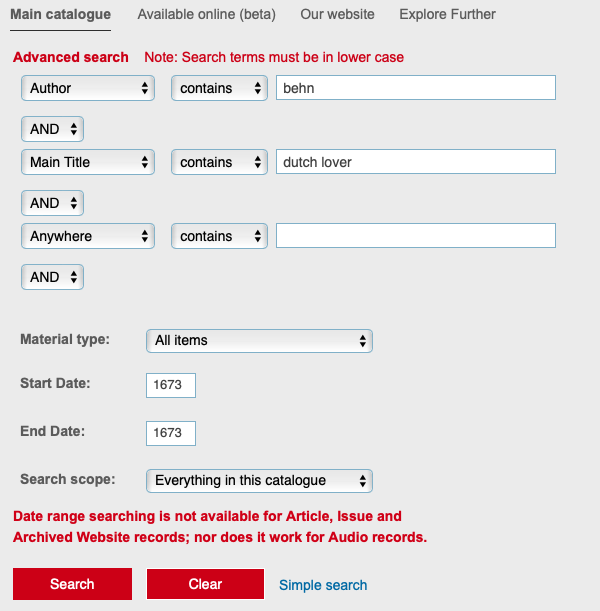

Sure enough, there is a result, and its shelfmark matches what's in the BL Labs' file, so I'm feeling pretty good about that.
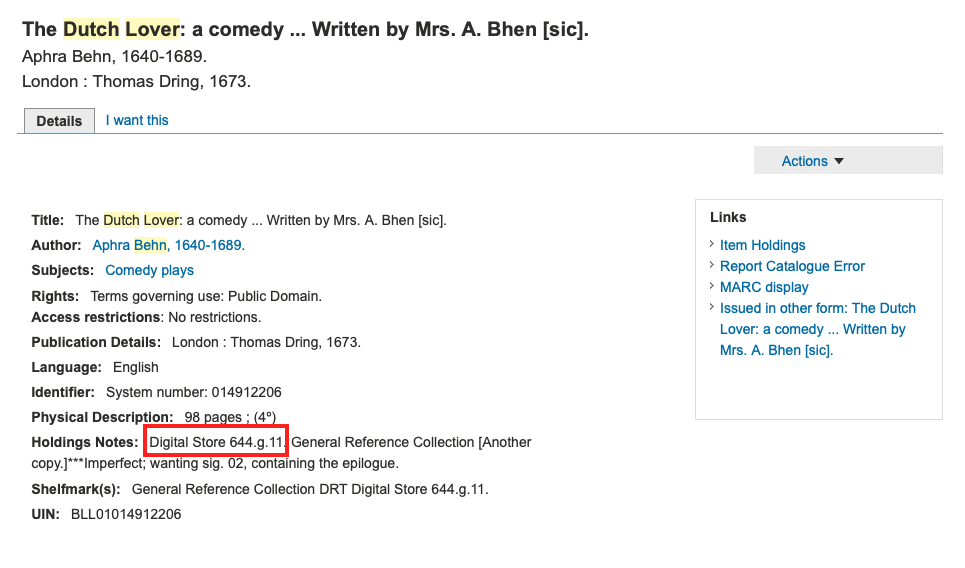

###2.a - How do we get these without having to search every time?
Great: this is the kind of page we want to reach. now we just need to figure out how to get to a catalogue record like this one without having to go through the search screen.

Fortunately, if we look at the URL for this page, we can see the same record id that's given in the BL Labs' metadata file... sort of.

`http://explore.bl.uk/primo_library/libweb/action/display.do?frbrVersion=2&tabs=moreTab&ct=display&fn=search&doc=BLL010`**14912206**`&indx=1&recIds=BLL01014912206&recIdxs=0&elementId=0&renderMode=poppedOut&displayMode=full&frbrVersion=2&vl(drEndYear4)=1673&vl(drStartMonth4)=01&dscnt=0&vl(1UIStartWith0)=contains&vl(2084770717UI1)=title&vl(1UIStartWith1)=contains&vl(1UIStartWith2)=contains&vl(2084770715UI0)=creator&mode=Advanced&vid=BLVU1&vl(boolOperator1)=AND&vl(2084770721UI3)=all_items&tab=local_tab&vl(boolOperator0)=AND&vl(2084770716UI2)=any&vl(drEndMonth4)=12&vl(freeText1)=dutch+lover&vl(drStartYear4)=1673&vl(boolOperator2)=AND&vl(freeText0)=behn&vl(drEndDay4)=31&vl(drStartDay4)=01&dstmp=1656714631870`

It's easier to see if we use the catalogue's 'Permalink' tool to get a link that doesn't have all of the parameters from our specific search:
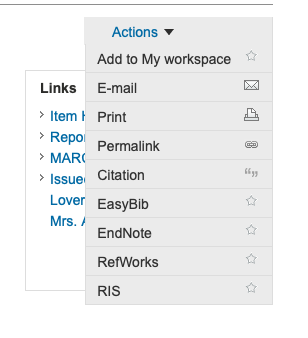

`http://explore.bl.uk/BLVU1:LSCOP-ALL:BLL010`**14912206**

Let's see what happens if we put a different `BL record id` from the metadata file in that spot: http://explore.bl.uk/BLVU1:LSCOP-ALL:BLL01014804964

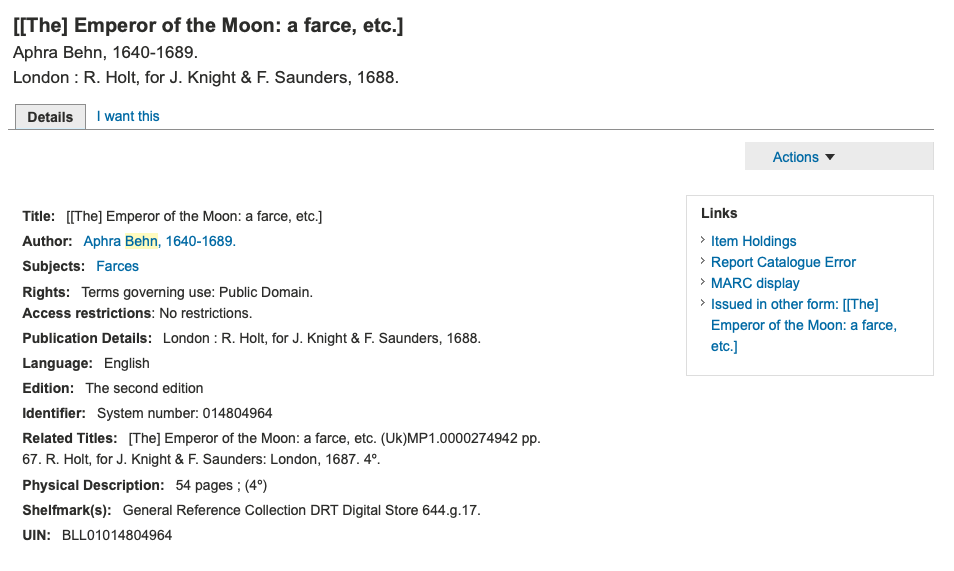

Okay, that's really promising: we can reliably retrieve any catalogue record we want by constructing a URL that starts predictably and ends with the value of the `BL record id` field in the metadata file we have.

Now, how do we get from here to a link to the book on the British Library's site?

###2.b - Examining the page we encounter as we see it
Because this page was designed with a human user in mind, the fastest way to figure out how it's supposed to work is probably by interacting with the page.

>*Note:* This is probably as good a time as any to acknowledge that everything in this reader is written under the assumption that you are a sighted user who's interacting with the British Library's web site by looking at the screen and using a mouse/keyboard. I have never tried any of this any other way (by using a screen reader, for example), and so am really not in a position to describe how these instructions might need to be adapted for, say, blind or low-vision researchers.

At first, we just get some metadata about the book, but near the top of the record, there's a link that reads 'I want this,' and if we click on that, we get a different view.

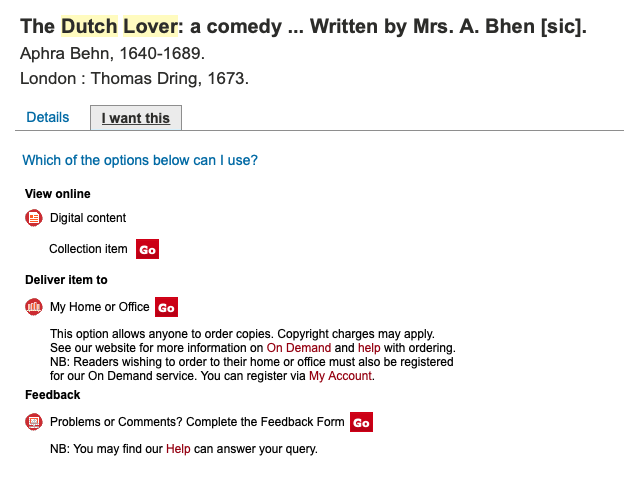

If we click the square, red "Go" button next to "Collection item" under the "Digital content" heading, we're taken to the scan of this book in the British Library's online viewer.

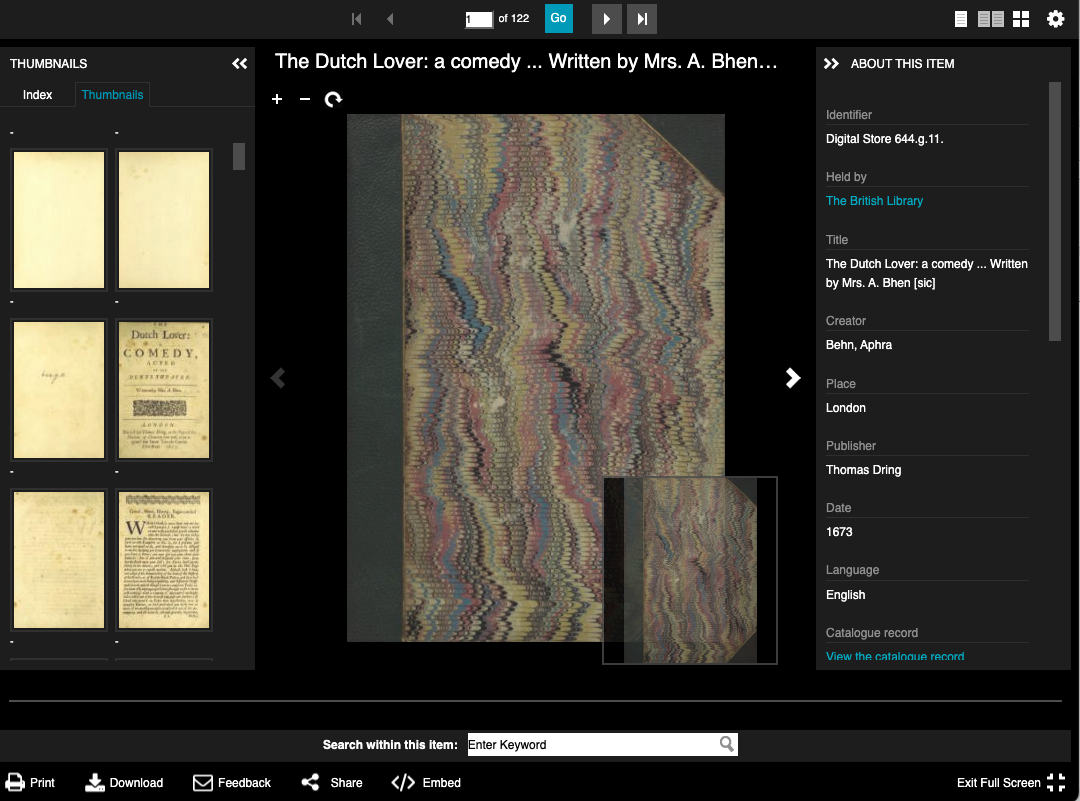

Now, that's what we're looking for. And, here again, if we compare the URLs for the viewer pages for *The Dutch Lover* and *The Emperor of the Moon*, they look like they're structured in a pretty predictable way:

**Dutch Lover:**

`http://access.bl.uk/item/viewer/ark:/81055/vdc_00000001ED08#?c=0&m=0&s=0&cv=0&xywh=-422%2C-148%2C2744%2C2945`

**Emperor of the Moon:**

`http://access.bl.uk/item/viewer/ark:/81055/vdc_00000002C84A#?c=0&m=0&s=0&cv=0&xywh=-337%2C-146%2C2715%2C2914`

It looks like its the number after `vdc_` and up to the octothorpe(`#`) that we're looking for. And, as an added bonus, it turns out that you can get to one of these reader pages with just the URL up to the end of that `vdc` number (e.g., http://access.bl.uk/item/viewer/ark:/81055/vdc_00000001ED08).

Unfortunately, the metadata file from the British Library Labs doesn't have those numbers anywhere. (I mean, if it did, do you really think I'd have spent this much time showing you screenshots?)

So we're going to have to back up a screen and figure out where we can get those numbers.

##3 - Figuring out *how* to get the information we want
Being able to get to the page is, shall we say, necessary but not sufficient: we still need to get the information that we want from that page once we've gotten to it.

We may not want all of the informaiton on the page—or even very much of it. So we need to identify the parts of the page that have the information we *do* want. If we can locate those, we can extract just the bits that interest us.

###3.a - Examining the page we encounter as the web browser sees it
Web pages like the ones we see in the British Library's catalogue are complicated assemblages: there's lots of stuff that's getting injected into the page by different bits of code. The HTML for one of these catalogue results ends up running to more than 2,000 lines, for example.

We don't necessarily have to understand everything about how this web page gets assembled to get the information we want from it, though, as long as we keep some basics of HTML in mind.

* A page written in HTML consists of a nested set of "elements."
* Element "tags" are given in angled brackets and there's generally both an opening and a closing tag for each element (the contents of the element are between the opening and closing tags).
* In addition to their actual contents (often referred to as "node values"), elements can have various "attributes" that can dictate the element's function, be used for styling, etc.

Running the code in the next cell will produce a very simple HTML "page." If you haven't worked with HTML before, you can study the HTML in the code cell and look at the output to see how the parts come together.

In [ ]:
#Code cell 15
%%html
<html>
  <head>
    <!--Information about the page goes here, normally along with links to scripts,
    stylesheets, etc. This simple HTML puts the styling information "inline" in the header.-->
    <style type="text/css">
      body { width: 40%;}
      h1 { color: #496fad;
         }
      div { margin-bottom: 1em; }
      .maintext { font-family: serif;
                  font-size: 13pt;
                }
      .blockquote { font-family: italic;
                    margin: 0em 3em 1em 3em;
                    padding: 0.5em;
                    background-color: #dedede;
                  }
      form { margin-top: 2em; }
      form label { font-weight: bold;
                   font-size: 11pt;
                 }
      #comment { width: 100%; }
      #submitbutton { float: right;
                      font-weight: bold;
                      font-size: 10pt;
                      background-color: #9dbaf5;
                      padding: 10px;
                      border: none;
                      border-radius: 10px;
                    }
    </style>
  </head>
  <body>
    <!--The actual content of the page that you end up seeing.-->
    <h1>A very simple HTML page</h1>
    <div class="maintext">A content <code>div</code>. This element has a
    <code>class</code> attribute that identifies it for one set of visual
    styling rules.</div>
    <div class="blockquote">This is another content <code>div</code>, with a
    different <code>class</code> attribute for very different styling. </div>
    <div class="maintext">Note that the elements in the form below have
      <code>id</code> attributes that <em>can</em> be used for visual styling,
      but also identify those elements for functional purposes.</div>
    <form id="feedback" action="/post_comment.php">
      <label for="comment">Tell us what you think!</label><br />
      <textarea rows="5" id="comment"
      placeholder="This form doesn't do actually do anything..."/></textarea>
      <input type="submit" id="submitbutton" value="Submit comment" />
    </form>
</body>
</html>

###3.b - Getting the stuff we want
We can get a view of the code behind the pages we're looking at using the "Developer Tools" that most web browsers include. (I believe that Developer Tools are on by default in Google Chrome and other Chromium-based browsers. If you're using Apple's Safari browser, you'll need to [turn on Developer Tools in Safari's preferences](https://support.apple.com/guide/safari/use-the-developer-tools-in-the-develop-menu-sfri20948/mac).)

In Chrome (and related browsers), you can access Developer Tools from the View menu: `View > Developer > Developer tools`. (In Safari, once you've turned on the `Develop` menu, you can select `Develop > Web Inspector`.) Clicking on the small icon showing a mouse cursor over a square will allow you to inspect any element on the page: just move your mouse over the part of the page you want to learn more about and Developer Tools will show you the relevant part of the page's HTML. (In Safari's Web Inspector, you're looking for an icon that looks like crosshairs.)



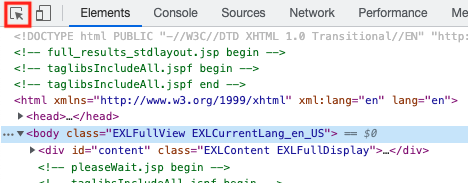

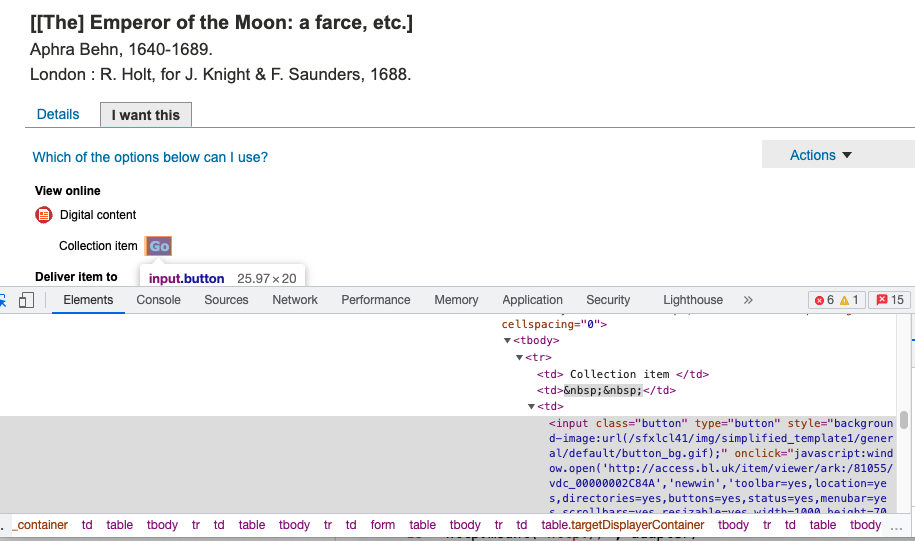

The HTML for that button turns out to be this:

`<input class="button" type="button" style="background-image:url(/sfxlcl41/img/simplified_template1/general/default/button_bg.gif);" onclick="javascript:window.open(`**'http://access.bl.uk/item/viewer/ark:/81055/vdc_00000002C84A'**`,'newwin','toolbar=yes,location=yes,directories=yes,buttons=yes,status=yes,menubar=yes,scrollbars=yes,resizable=yes,width=1000,height=700');newwin.focus;" value="Go" title="Navigate to target in new window">`

And, sure enough, there's a link we can recognize buried in there. So we're getting close.

But remember that that red, square "Go" button only appeared when we clicked "I want this." It wasn't there in the initial view we got using the Permalink from the British Library's catalogue. And if we go back to that view, we won't see this same code in the HTML. So we know *what* we're looking for, but we need to be able to find it in a different place.


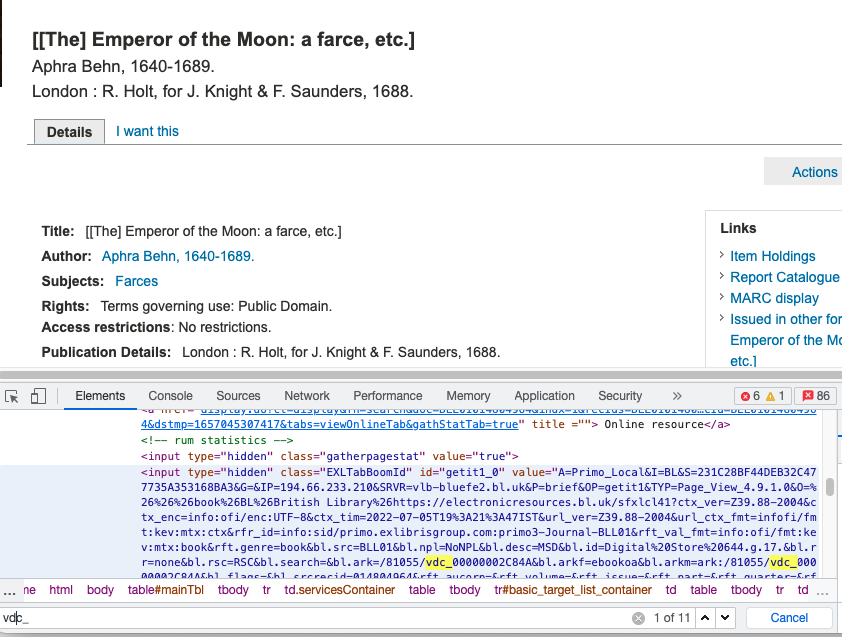

Fortunately, Developer Tools allows us to search the code as we're inspecting it, so we can see that that `vdc_` number is there on the page we get using a catalogue Permalink, even if there's nothing in that view that we can interact with to take us there:

`<input type="hidden" class="EXLTabBoomId" id="getit1_0" value="A=Primo_Local&amp;I=BL&amp;S=4C400CAE415B7E3258A797445E636C74&amp;G=&amp;IP=194.66.233.210&amp;SRVR=vlb-bluefe2.bl.uk&amp;P=brief&amp;OP=getit1&amp;TYP=Page_View_4.9.1.0&amp;O=%26%26%26book%26BL%26British Library%26https://electronicresources.bl.uk/sfxlcl41?ctx_ver=Z39.88-2004&amp;ctx_enc=info:ofi/enc:UTF-8&amp;ctx_tim=2022-07-01T23%3A55%3A44IST&amp;url_ver=Z39.88-2004&amp;url_ctx_fmt=infofi/fmt:kev:mtx:ctx&amp;rfr_id=info:sid/primo.exlibrisgroup.com:primo3-Journal-BLL01&amp;rft_val_fmt=info:ofi/fmt:kev:mtx:book&amp;rft.genre=book&amp;bl.src=BLL01&amp;bl.npl=NoNPL&amp;bl.desc=MSD&amp;bl.id=Digital%20Store%20644.g.17.&amp;bl.rr=none&amp;bl.rsc=RSC&amp;bl.search=&amp;bl.ark=/81055/`**vdc_00000002C84A**`&amp;bl.arkf=ebookoa&amp;bl.arkm=ark:/81055/`**vdc_00000002C84A**`&amp;bl.flags=&amp;bl.srcrecid=014804964&amp;rft.aucorp=&amp;rft.volume=&amp;rft.issue=&amp;rft.part=&amp;rft.quarter=&amp;rft.ssn=&amp;rft.spage=&amp;rft.epage=&amp;rft.pages=&amp;rft.artnum=&amp;rft.issn=&amp;rft.eissn=&amp;rft.isbn=&amp;rft.sici=&amp;rft.coden=&amp;rft_id=info:doi/&amp;rft.object_id=&amp;rft_dat=<BLL01>014804964</BLL01>&amp;rft.eisbn=&amp;rft_id=info:oai/&amp;rft.atitle=&amp;rft.jtitle=&amp;rft.btitle=%5B%5BThe%5D%20Emperor%20of%20the%20Moon:%20a%20farce,%20etc.%5D&amp;rft.856_url=%26&amp;O1=Primo Local&amp;O2=BLL01&amp;O3=BLL01014804964&amp;O4=delivery,tab1_onl_norestrict,&amp;O5=44BL.BL.PPRD&amp;O6=&amp;O7=0&amp;O8=&amp;O9=BLVU1&amp;O12=1&amp;O13=BLL01&amp;O14=&amp;O15=&amp;O16=&amp;O17=local_tab&amp;O18=&amp;O23=&amp;">`

###3.c - Searching and navigating the page's HTML
So now we know that, when we get the HTML for a page like this one, we can find the `vdc_` number. We just have to figure out how to extract it from a long string of what looks like gibberish.

The first step is noting *where* the long string of gibberish appears: it's in  the `value` attribute of an `input` element that has several other attributes:

| attribute | value |
|:----------|:------:|
|`type`| `"hidden"`|
|`class`| `"EXLTabBoomId"`|
|`id`|`"getit1_0"`|

While we could use any of these attributes to locate the element we want, `id` is going to be the best bet: there are 121 `input` elements with a `type` of `"hidden"` and 12 with the `class` `"EXLTabBoomId"`; but there's only one with the `id` `"getit1_0"`.

##4 - Actually scraping (linear workflow)
Now that we know what element we're looking for, we can use the record identifiers from the metadata file to construct URLs to retrieve the catalogue records, extract the value we're looking for, and then retrieve just the `vdc_number`.

>*Note:* We're going to refactor this code in a minute to make it more modular and reusable for different purposes. But I wanted to walk through the entire process in one place before breaking it up into separate functions.

The next block of code defines a function that we can call for every catalogue record we want to retrieve. There are a few different things going on in this next block of code, so I'll use comments in the code to describe things as we go. At a high level, though, this next block

1. Imports necessary packages;
2. Defines a function (accepting a parameter called `rec_id`) and:

  a. Define parameters to improve our chances of successfully retrieving the pages we want, even if we run into intermittent server errors;

  b. Construct a URL and retrieve the resource at that address;

  c. Parse the content of the web page using the BeautifulSoup package (yes, that's really what it's called);

  d. Construct and search for a pattern to find the `vdc_` number(s);

  e. Returns the `vdc_` number(s) that it finds.

3. Runs a test of our function with the record id 14804964.

In [ ]:
#Code cell 16

#1. Import packages: requests (and related) for retrieving the contents of the
#web page; BeautifulSoup for parsing the HTML; re [Regular Expressions] for
#defining and searching for a pattern of text to identify vdc_ numbers

import requests
import urllib3
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from bs4 import BeautifulSoup
import re

#2. Define a function accepting rec_id as an argument
def retrieve_vdc_simple(rec_id) :
  #2.a. Create a pattern for retrieving URLs that can tolerate some intermittent
  #server problems by retrying failed requests
  #Historical note: On updating this notebook, I learned about a change to the
  #urllib3 package. The "allowed_methods" parameter in line 23 used to be
  #"methods_whitelist." See https://github.com/urllib3/urllib3/issues/1916
  retry_strategy = Retry(
      total=3,
      status_forcelist=[429, 500, 502, 503, 504],
      allowed_methods=["GET"]
  )
  adapter = HTTPAdapter(max_retries=retry_strategy)
  #Note that the actual connection to the resource is given the variable name
  #http. In other code you'll see online, you'll often see requests.get(url).
  #This is more or less what's happening here; without a retry strategy, though,
  #a scraping script can be quite brittle, failing at the first server error it
  #encounters.
  http = requests.Session()
  http.mount("https://", adapter)
  http.mount("http://", adapter)
  headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
  }

  #2.b Construct and retrieve a URL that takes the basic form of the permalink to
  #a BL catalogue record with the rec_id parameter added to the end (as a string)
  rec_url = 'http://explore.bl.uk/primo_library/libweb/action/display.do?frbrVersion=4&tabs=moreTab&ct=display&fn=search&doc=BLL010' + str(rec_id) + \
  '&vid=BLVU1&lang=en_US&institution=BL'
  rec_r = http.get(rec_url, headers=headers)

  #2.c Pass the content of the retrieved result to BeautifulSoup for parsing
  rec_soup = BeautifulSoup(rec_r.content, 'html.parser')

  #2.d Construct a regular experession pattern to find vdc_ numbers and hold
  #on to them using a capture pattern
  viewer_pattern = re.compile(r'vdc_([A-Za-z0-9\.]+)')

  #Find the input element with id "getit1_0" using BeautifulSoup's find_all() method
  view_button = rec_soup.find_all('input', id='getit1_0')

  #There are some ghost records in the metadata file: if there's not actually a
  #view_button on the page we retireve, return 'None found' and move on
  if len(view_button) == 0 :
    return 'None found'

  else :
    #Python's re.findall() returns a list of all matches of the regular expression.
    vdc_list = re.findall(viewer_pattern, view_button[0]['value'])
    print(vdc_list)
    #The vdc_number can appear multiple times in the value attribute, but
    #sometimes there are actually multiple vdc_ numbers for a record: there could
    #be multiple volumes, or there could be more than one scan of the same volume
    #(e.g., one by Google, one by the British Library). We want all of the
    #vdc_ numbers, but we only need each one once.
    #
    #Note: I first wrote this code in a slightly less efficient way in hopes
    #that capturing the vdc_ numbers in the same order that they appeared would
    #make the vdc_ numbers line up with the shelfmarks in the metadata for
    #records that also had multiple shelfmarks. That turned out to be wishful
    #thinking: there doesn't appear to be any consistency between the metadata
    #file and the catalogue record.
    #
    #This one-liner uses set() to get the distinct results, then wraps that set
    #in list() to turn the set back into a list.

    vdc_distinct_list = list(set(vdc_list))
    #If there's just one vdc_ number, prepend "vdc_" to it and make that the
    #value of the variable vdc
    if len(vdc_distinct_list) == 1 :
      vdc = 'vdc_' + vdc_distinct_list[0]
    #If there are multiple vdc_ numbers...
    else :
     #Prepend  "vdc_" to each of them and make a list
     multi_vdc = ['vdc_' + vdc_item for vdc_item in vdc_distinct_list]
     #Join together all of the items in that list, separated by a pipe character
     vdc = '|'.join(multi_vdc)

    #2.e Return the resulting vdc_number(s)
    return vdc

#3. Test our function using a record identifier
test = retrieve_vdc_simple(14816272)
test

##5 - Actually scraping (modularized workflow): "Re-factoring" our code to use functions
If all we needed to do was to retrieve the `vdc_` number(s) for each catalogue record, we could go ahead and start scraping now.

But our scraping workflow is going to end up being a little bit more complex: we're going to go on to make a second pass at a different set of URLs using the information we'll get with this first query.

This presents us with an opportunity to modularize our code: rather than duplicating the code to retrieve a URL, we can define a function and write that code once, then invoke that function in different contexts as needed.

These next cells split the code in code cell 16 into two different parts:

1. One function is concerned solely with constructing an http request with a retry strategy;
2. A second function that contains just the logic for extracting the `vdc_` numbers from catalogue records.

Dividing things up this way means that each function does only one thing, but that means that whenever we find ourselves needing to do that one thing, we already have the code for it.

In [ ]:
#Code cell 17
#Note that these packages have already been imported, so we don't really need
#these import statements. I've left them here so that the code will still work
#if you skipped over code cell 16.
import requests
import urllib3
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

#This function defines an http request with a retry strategy. It accepts a URL
#as an argument, requests the URL using our defined http connection, and returns
#the response to that request
def create_http(url) :
  retry_strategy = Retry(
      total=3,
      status_forcelist=[429, 500, 502, 503, 504],
      allowed_methods=["GET"]
  )
  adapter = HTTPAdapter(max_retries=retry_strategy)
  http = requests.Session()
  http.mount("https://", adapter)
  http.mount("http://", adapter)
  headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
  }

  r = http.get(url, headers=headers)

  return r

In [ ]:
#Code cell 18
#Again, importing packages in case we've skipped over an earlier cell
from bs4 import BeautifulSoup
import re
def retrieve_vdc(rec_id) :
  #Construct a URL incorporating the rec_id parameter
  rec_url = 'http://explore.bl.uk/primo_library/libweb/action/display.do?frbrVersion=4&tabs=moreTab&ct=display&fn=search&doc=BLL010' + \
  str(rec_id) + '&vid=BLVU1&lang=en_US&institution=BL'

  #pass the URL we just constructed to the create_http function we defined in
  #code cell 17: we are calling a function from inside another function
  rec_r = create_http(rec_url)

  #Pass the content of the response to BeautifulSoup for parsing
  rec_soup = BeautifulSoup(rec_r.content, 'html.parser')

  #See comments in code cell 16
  viewer_pattern = re.compile(r'vdc_([A-Za-z0-9\.]+)')
  google_pattern = re.compile(r'books\.google\.com.+vid%253DBL%253A([A-Za-z0-9]+)%2520')
  view_button = rec_soup.find_all('input', id='getit1_0')
  if len(view_button) == 0 :
    return 'None found'
  else :
    vdc_list = re.findall(viewer_pattern, view_button[0]['value'])
    print(vdc_list)
    vdc_distinct_list = list(set(vdc_list))
    if len(vdc_distinct_list) == 1 :
      vdc = 'vdc_' + vdc_distinct_list[0]
    else :
     multi_vdc = ['vdc_' + vdc_item for vdc_item in vdc_distinct_list]
     vdc = '|'.join(multi_vdc)
    return vdc

#We should get exactly the same result as in code cell 16
newtest = retrieve_vdc(14816272)
newtest

###5.a - Get the vdc_ numbers for some of our records (i.e., *actually* actually scraping)
With the functions we've defined in code cells 17 and 18, we can retrieve `vdc_` numbers for any record or records we want. Let's get them for the works by Aphra Behn that we identified back in code cell 11. (I also want to get one other record to illustrate something for the next step.)



In [ ]:
#Code cell 19
#A case in which several volumes were scanned twice: once by Google, then again by
#the British Library, itself. We created this DataFrame earlier, in code cell 11.
#
pre_1801_behn['vdc'] = pre_1801_behn['BL record ID'].apply(retrieve_vdc)
pre_1801_behn

In [ ]:
#Code cell 20
#A single record providing a well-behaved example where two copies of a title
#were both scanned.
shakespeare_quarto = pre_1801.loc[pre_1801['BL record ID'] == 14824047].copy()
shakespeare_quarto['vdc'] = shakespeare_quarto['BL record ID'].apply(retrieve_vdc)

##6 - Going back for a second scraping pass to double-check metadata for each vdc_ number
For our purposes, we don't need to go into every quirk of this dataset, but it's worth noting that some of these records have *multiple* `vdc_` numbers—indeed, that's the case for *most* of the works we've identified by Aphra Behn.

This can happen for a few different reasons:

1. Multi-volume works have separate `vdc_` numbers for each volume.
2. Multiple holdings of a single title can be consolidated into one record. If multiple copies have been scanned, there's a different `vdc_` number for each copy. Unfortunately, the metadata file doesn't make it possible to reliably associate a retrieved `vdc_` number with the correct shelfmark.
3. A single volume can have been scanned multiple times (by Google and by the British Library), with different terms of use for each scan: scans made by Google are not to be re-circulated, while scans made by the British Library, itself, are declared Public Domain.

We can't always tell from the British Library Labs' metadata file just what the case is, but we can get a clearer picture by retrieving the IIIF manifest for the scan, which includes additional metadata concerning that can help to confirm the shelfmark of the volume that was scanned and establish the terms of use.

Just as we did when we were trying to figure out how to retrieve catalogue records, we can figure out how to get at the IIIF manifests for the British Library's scans by inspecting the HTML of a book viewer page.

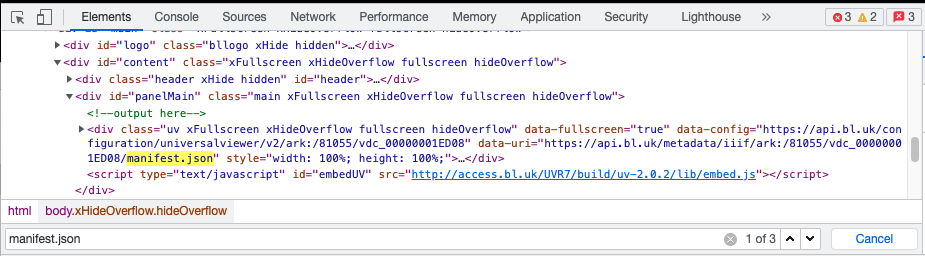


I wish I could say that checking the manifests can clear up every ambiguity, but that doesn't always turn out to be the case. The way that shelfmarks are handled in these records mean that it's only rarely possible to sort out multi-volume works definitively, for instance. But the manifests can generally resolve questions about multiple holdings (of single-volume works, at least) and about multiple scans. Whatever the case, it can be worth our while to double check each `vdc_` number to see what we *can* figure out.

To do that, I'm going to first make sure there's a separate row for each `vdc_` number.


1. Creating a new object called `vdc` and assign it the values created by splitting the multi-valued cells on the pipe character (`|`).
2. Use `explode()` to create enough new rows to accommodate all of the values just assigned to `vdc`. Existing columns are simply copied. Because we gave our new object the same name as an exiting column, that column is overwritten with the exploded values.

Code cell 22 performs this transformation on the `shakespeare_quarto` DataFrame and then prints it out so we can see what happens. (We'll revisit the `pre_1801_behn` set in a bit.)


In [ ]:
#Code cell 22
shakespeare_quarto = (
    #Create a new object by splitting the vdc column into a list on the pipe character
    shakespeare_quarto.assign(vdc=shakespeare_quarto['vdc'].str.split('|'))
      #Explode the new vdc object into multiple rows
      .explode('vdc')
      #Reset the indices for the rows of the DataFrame: don't try to hold on to
      #the existing indices, just accept new defaults (since we're creating rows
      #where there weren't any before)
      .reset_index(drop=True)
)
shakespeare_quarto

###6.a - Confirming shelfmarks
Note how, in this case, the `BL shelfmark` column contains two different shelfmarks. This is exactly the kind of case that we can resolve by checking the manifest. A IIIF manifest is a JSON document, so, rather than using BeautifulSoup, we'll handle it the same way we did the results from the GeoNames API.

In [ ]:
#Code cell 23
import json

def confirm_shelfmark(vdc_num) :
  #Construct a URL to retrieve the IIIF manifest
  iiif_manifest_url = 'https://api.bl.uk/metadata/iiif/ark:/81055/' + vdc_num + '/manifest.json'
  print(iiif_manifest_url)
  #Call the create_http function to retrieve the manifest
  manifest_r = create_http(iiif_manifest_url)

  #Check to see if we succeeded in retrieving a manifest: there are some ghost
  #records in the metadata file which will return errors if we attempt to
  #retrieve them.
  try :
    #Parse the JSON from our retrieved request
    manifest_json = json.loads(manifest_r.text)
    #Get the 'metadata' object in the JSON
    metadata = manifest_json['metadata']
    confirmed_shelfmark = ''
    #Iterate through the objects in the metadata object, looking for one that
    #has the label "Identifier", then updating the confirmed_shelfmark variable
    #with the value of that object
    for metadata_item in metadata :
      if metadata_item['label'] == 'Identifier' :
        confirmed_shelfmark = metadata_item['value']
    return confirmed_shelfmark
  #If we stumbled on a bad record, return a simple message
  except :
    return ('Not found')

In [ ]:
#Code cell 24
#Get the proper shelfmark for each vdc_ number using the confirm shelfmark function
shakespeare_quarto['confirmed_shelfmark'] = shakespeare_quarto['vdc'].apply(confirm_shelfmark)
shakespeare_quarto

So now we've connected each scan to the correct shelfmark.

(This one proves to be an at least somewhat interesting case, because while the two scans have different title pages—one dated 1681, the other dated 1691—the actual text certainly appears to be the same setting of type: my hunch is that the title page of 644.f.67 is probably a cancel, though the scan, unfortunately, doesn't include enough of the gutter to know for sure.)

###6.b - Checking license terms
Now let's return to the set of Behn's works we identified earlier. First, we'll create separate rows for each `vdc_` number, as in code cell 22.

In [ ]:
#Code cell 25
pre_1801_behn = (
    pre_1801_behn.assign(vdc=pre_1801_behn['vdc'].str.split('|'))
      .explode('vdc')
      .reset_index(drop=True)
)
pre_1801_behn

You can probably guess just by looking at the rows in this DataFrame what the pattern is. We can take *The Younger Brother* as an example (since it's at the end of the DataFrame and should be visible without any scrolling), but it's true of several titles in this set: we get the same shelfmark twice, but with different `vdc_`. In each case where we have a `vdc_` number that includes ".0x000001" we're looking at scan performed by Google; the other `vdc_` numbers are for the British Library's scans.

With a pattern this clear, it hardly seems necessary to even check the manifests, but there might be other variations in the larger dataset, so it's probably worth doing, just to be sure.

Code cell 26 expands on the `confirm_shelfmark` function to do more with the IIIF manifests.

In [ ]:
#Code cell 26
import json
def check_manifest(vdc_num) :
  iiif_manifest_url = 'https://api.bl.uk/metadata/iiif/ark:/81055/' + vdc_num + '/manifest.json'
  print(iiif_manifest_url)
  manifest_r = create_http(iiif_manifest_url)
  try :
    manifest_json = json.loads(manifest_r.text)
    metadata = manifest_json['metadata']
    confirmed_shelfmark = ''
    for metadata_item in metadata :
      if metadata_item['label'] == 'Identifier' :
        confirmed_shelfmark = metadata_item['value']
    #Look for the license object in the JSON, too
    license_terms = manifest_json['license']
    #Check to see if the value of the license object includes "creativecommons",
    #"google", or... something else.
    if license_terms.find('creativecommons') != -1 :
      license = 'Public Domain'
    elif license_terms.find('google') != -1 :
      license = 'Google Books'
    else :
      license = license_terms
    #Find the link to the book's title page (used as a thumbnail)
    title_page_link = manifest_json['thumbnail']['@id']
    #Return a list including the confirmed shelfmark, the license, and the link
    #to the title page
    return [confirmed_shelfmark, license, title_page_link]
  except :
    return ('Not found')



In [ ]:
#Code cell 27
#This one's a little tricky: we're adding two columns to the DataFrame: we pass
#a list of columns to add. We populate that list of columns using a list of values
#created from a list comprehension of value returned by the check_manifest
#function
pre_1801_behn[['confirmed_shelfmark', 'license', 'title_page']] = [result for result in pre_1801_behn['vdc'].apply(check_manifest)]
pre_1801_behn

##7 - Creating links to the book viewer and IIIF manifest
In a way, we've already touched on this next step when we were looking at the URLs of different pages to figure out how to retrieve different bits of information: having the `vdc_` number is enough to allow us to generate a URL to the IIIF manifest and to the book viewer page for each volume. For the sake of convenience, let's add columns with those links to our dataframes.

In [ ]:
#Code cell 28
def add_links(vdc_num) :
  viewer_link = 'http://access.bl.uk/item/viewer/ark:/81055/' + vdc_num
  iiif_manifest = 'https://api.bl.uk/metadata/iiif/ark:/81055/' + vdc_num + \
    'manifest.json'
  return([viewer_link, iiif_manifest])

shakespeare_quarto[['book_viewer', 'iiif_manifest']] = [i for i in shakespeare_quarto['vdc'].apply(add_links)]

pre_1801_behn[['book_viewer', 'iiif_manifest']] = [i for i in pre_1801_behn['vdc'].apply(add_links)]

In [ ]:
#Code cell 29
#Have a look at the cells we just added to the shakespeare_quarto DataFrame
shakespeare_quarto[['confirmed_shelfmark', 'book_viewer', 'iiif_manifest']]

In [ ]:
#Code cell 30
#Create a subset of Behn's works with a Public Domain license and see what we have
pre_1801_behn_public_domain = pre_1801_behn.loc[pre_1801_behn['license'] == 'Public Domain'].copy()
pre_1801_behn_public_domain[['Title', 'confirmed_shelfmark', 'book_viewer', 'license', 'title_page']]

## 8 - Downloading the title pages
This next step is optional, of course, but it illustrates how we could download and save the title pages that we identified.

In [ ]:
#Code cell 31
#Import package
import os

#Check to see if the directory exists. If not, create it and set it as the output
#directory
if not os.path.exists('/gdrive/MyDrive/rbs_digital_approaches_2023/output/behn_titlepages/') :
  os.makedirs('/gdrive/MyDrive/rbs_digital_approaches_2023/output/behn_titlepages/')
output_dir = '/gdrive/MyDrive/rbs_digital_approaches_2023/output/behn_titlepages/'

#Iterate through the rows of the dataframe. Retrieve the title page files using
#the create_http function and save them to our output directory
for index, row in pre_1801_behn_public_domain.iterrows() :
  vdc = row['vdc']
  get_tp = create_http(row['title_page'])
  with open(output_dir + vdc + '_tp.jpg', 'wb') as file :
    print('Saving ' + vdc + '_tp.jpg...')
    file.write(get_tp.content)

##Conclusion
While it's always nice when the data you want is available through a convenient API, sometimes you end up having to extract data from web pages that were designed to be viewed on screen. Examining a page's HTML will usually tell you what you need to know to get the data you're looking for, and automating the retrieval of that information can be a huge time savings.